## Udacity Data Scientist Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

## Getting Started

In this project, I will employ several supervised algorithms to accurately model individuals' income using data collected from the 1994 U.S. Census. I will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. My goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data I investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


In [2]:
data.tail(5)

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
45217,33,Private,Bachelors,13.0,Never-married,Prof-specialty,Own-child,White,Male,0.0,0.0,40.0,United-States,<=50K
45218,39,Private,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K
45219,38,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
45220,44,Private,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K
45221,35,Self-emp-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,60.0,United-States,>50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000.

In [3]:
#Total number of records
n_records = len(data)

#Number of records where individual's income is more than $50,000
n_greater_50k = len(data[data['income'] == '>50K'])

#Number of records where individual's income is at most $50,000
n_at_most_50k = len(data[data['income'] == '<=50K'])

#Percentage of individuals whose income is more than $50,000
greater_percent = n_greater_50k * 100 / len(data)

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(round(greater_percent,2)))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

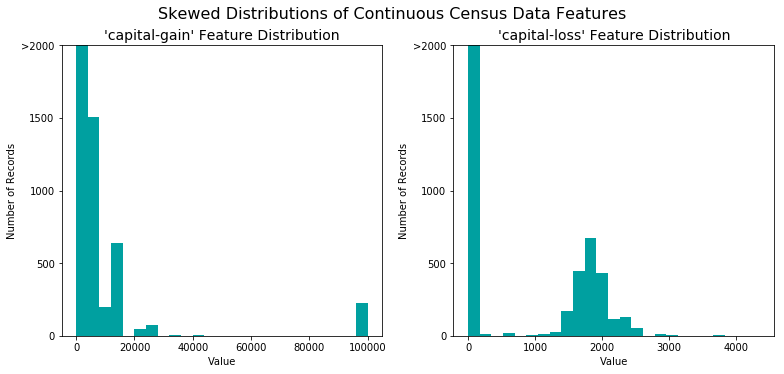

In [4]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

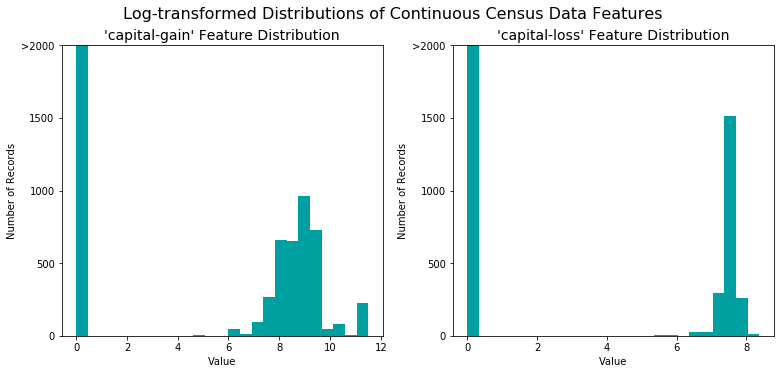

In [5]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

I will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [6]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [7]:
features_log_minmax_transform

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.000000,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.000000,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.000000,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.000000,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.000000,0.397959,Cuba
5,0.273973,Private,Masters,0.866667,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.000000,0.000000,0.397959,United-States
6,0.438356,Private,9th,0.266667,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.000000,0.000000,0.153061,Jamaica
7,0.479452,Self-emp-not-inc,HS-grad,0.533333,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.000000,0.448980,United-States
8,0.191781,Private,Masters,0.866667,Never-married,Prof-specialty,Not-in-family,White,Female,0.829751,0.000000,0.500000,United-States
9,0.342466,Private,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.742849,0.000000,0.397959,United-States


In [8]:
#One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

#Encode the 'income_raw' data to numerical values
income = data['income'].replace(['>50K', '<=50K'], [1, 0])

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
# print encoded

103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [9]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
X_train.head()

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
13181,0.410959,0.600000,0.0,0.000000,0.500000,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
10342,0.438356,0.533333,0.0,0.000000,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
20881,0.054795,0.666667,0.0,0.000000,0.357143,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
24972,0.301370,0.866667,0.0,0.905759,0.448980,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
43867,0.246575,0.600000,0.0,0.000000,0.500000,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


----
## Evaluating Model Performance
In this section, I will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals who make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most 50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Question 1 - Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset?

** Please note ** that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.

In [11]:
'''
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''
#Calculate accuracy, precision and recall
accuracy = np.sum(income) / len(income)
recall = np.sum(income) / (np.sum(income) + 0)
precision = np.sum(income) / (len(income))

#Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1+0.5**2)*(precision * recall)/((0.5**2 * precision) + recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models

### Question 2 - Model Application
I chose three models to try.

#### Gaussian Naive Bayes

- Describe one real-world application in industry where the model can be applied.
    <br>- We can use this to predict any categorical variable.  For instance, we could use this to predict whether a credit card application was accepted or declined.<br>
<br>
- What are the strengths of the model; when does it perform well?
    <br>- It's easy to run and can work with very large numbers of features.<br>
<br>
- What are the weaknesses of the model; when does it perform poorly?
    <br>- It performs poorly when it is too naive.  For instance, it may not pick up on the full meaning of phrases when used in text predictions.<br>
<br> 
- What makes this model a good candidate for the problem, given what you know about the data?
    <br>- I think this model is worth a shot given that there are so many feature variables.  Also, these feature variables don't seem too likely to be related to one another, so its naivety may not be a drawback.<br>
<br> 
- Reference:  https://www.youtube.com/watch?v=nfbKTrufPOs
<br>

#### AdaBoost

- Describe one real-world application in industry where the model can be applied.
    <br>- We can use this to predict any categorical variable.  For instance, we could use this to predict whether a credit card application was fraud or not.<br>
<br>
- What are the strengths of the model; when does it perform well?
    <br>- It can be used without modifying too many parameters.  It has been used successfully in everything from biology to computer vision to speech processing.<br>
<br>
- What are the weaknesses of the model; when does it perform poorly?
    <br>- It can be sensitive to outliers.  So, noisy data may cause problems for it.<br>
<br> 
- What makes this model a good candidate for the problem, given what you know about the data?
    <br>- I plan on pursuing this model because of how adaptive it is and how I can examine different weak classifiers.<br>
<br> 
- Reference:  http://www.nickgillian.com/wiki/pmwiki.php/GRT/AdaBoost
    - http://user.ceng.metu.edu.tr/~tcan/ceng734_f1112/Schedule/adaboost.pdf
<br>

#### Logistic Regression

- Describe one real-world application in industry where the model can be applied.
    <br>- We can use this to predict any categorical variable.  For instance, we could use this to predict whether a customer's problem was able to be solved through an automated system or required manual interaction with an employee.<br>
<br>
- What are the strengths of the model; when does it perform well?
    <br>- It's easy to interpret and generally avoids over-fitting.  It performs well when finding more simple relationships between features.<br>
<br>
- What are the weaknesses of the model; when does it perform poorly?
    <br>- It can be too simple.  When the data has complex relationships between features, then logistic regression will likely miss it.<br>
<br> 
- What makes this model a good candidate for the problem, given what you know about the data?
    <br>- I like comparing more computer-science based models with a classical, statistical approach.  Also, there's a chance this data has fairly simple relationships, and logistic regression will find that if it exists.<br>
<br> 
- Reference:  https://elitedatascience.com/machine-learning-algorithms

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model I've chosen, it's important that I create a training and predicting pipeline that allows me to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. My implementation here will be used in the following section.

 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.

In [12]:
#Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    #Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner.fit(X_train.values[:sample_size,:], y_train.values[:sample_size])
    end = time() # Get end time
    
    #Calculate the training time
    results['train_time'] = end - start
        
    #Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train.values[:300,:])
    end = time() # Get end time
    
    #Calculate the total prediction time
    results['pred_time'] = end - start
            
    #Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(predictions_train, y_train[:300])
        
    #Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(predictions_test, y_test)
    
    #Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
        
    #Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation

GaussianNB trained on 361 samples.
GaussianNB trained on 3617 samples.
GaussianNB trained on 36177 samples.
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.
LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.


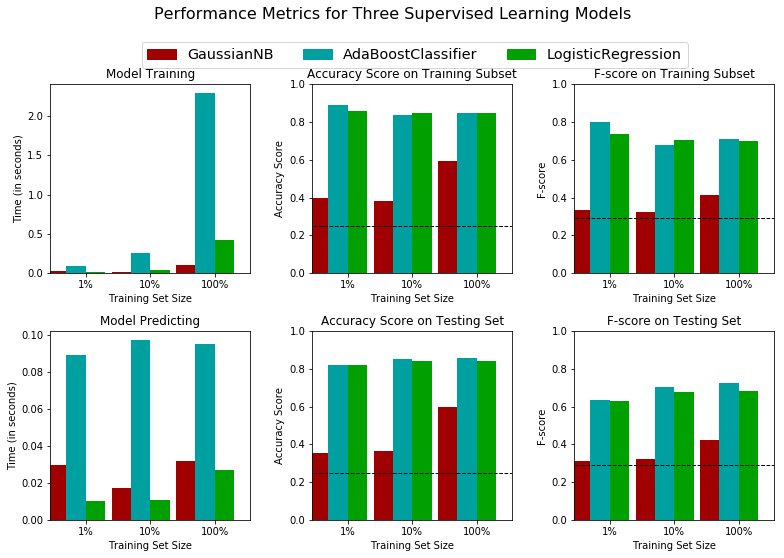

In [13]:
#Import the three supervised learning models from sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
seed = 42

#Initialize the three models
clf_A = GaussianNB()
clf_B = AdaBoostClassifier(random_state=seed)
clf_C = LogisticRegression(random_state=seed)


#Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(y_train)
samples_10 = int(len(y_train)*0.1)
samples_1 = int(len(y_train)*0.01)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results

### Question 3 - Choosing the Best Model

#### Adaboost and Logistic Regression drastically outperform the Gaussian Naive Bayes in terms of both accuracy and F score.
<br>

#### Adaboost and Logistic Regression both result in over 80% accuracy and have around a 70% F score when predicting the testing set.  Adaboost takes almost three times as long as Logistic Regression to run, but Adaboost still runs in under 0.1s.  I would choose Adaboost due to its superior predictive ability.

### Question 4 - Describing the Model in Layman's Terms

#### The final model I chose was Adaboost.  Adaboost works by combining many "weak learners" into a single "strong learner".  For instance, Adaboost can use decision trees as weak learners granted that each decision tree is better than simply guessing randomly.  Decision trees are simple decision algorithms like "If this automobile weighs more than 4,000lbs, it is a truck.  If it weighs less than 4,000lbs it is a car."  Adaboost works by combining the strengths of many different simple decision trees to create a final prediction.
<br>

#### In our census data, Adaboost worked with a combination of weak learners like, "If someone works more than 30 hours a week, they earn >50K", "If someone had more than 10,000 USD in capital gains, they earn >50K", etc.  Adaboost compared these weak learners to find which ones added the most information to our predictions, and the ones that added the most information were given the strongest voice in our final, strong learner.  So, while each weak learner gets a vote for what the prediction is, each weak learner's vote is weighted by how good it is at predicting.  The summation of these weighted weak learner votes gives us our final, "strong learner" prediction.
<br>

#### References:
https://www.quora.com/What-is-AdaBoost
<br>
https://machinelearningmastery.com/boosting-and-adaboost-for-machine-learning/

### Implementation: Model Tuning
I tune the model using GridSearchCV

In [14]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

# Initialize the classifier
clf = AdaBoostClassifier(random_state=seed)

# Create the parameters list you wish to tune, using a dictionary if needed.
parameters = {'n_estimators':[10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
             'learning_rate':[0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring = scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-sco

Unoptimized model
------
Accuracy score on testing data: 0.8576
F-score on testing data: 0.7246

Optimized Model
------
Final accuracy score on the testing data: 0.8610
Final F-score on the testing data: 0.7311


### Question 5 - Final Model Evaluation

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |   Naive Benchmark   |
| :------------: | :---------------: | :-------------: | :-------------: | 
| Accuracy Score |      0.8576       |      0.8610     |      0.2478     |
| F-score        |      0.7246       |      0.7311     |      0.2917     |


#### The optimized scores are better than the unoptimized but not by a lot.
<br>

#### The optimized model is around 61 points better than the Naive model in terms of accuracy and 44 points better than the Naive model in F score

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, which five features are the most important for prediction?

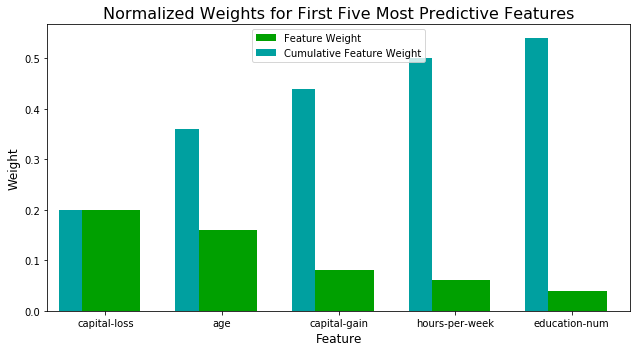

In [15]:
# Import a supervised learning model that has 'feature_importances_'


# Train the supervised model on the training set using .fit(X_train, y_train)
model = AdaBoostClassifier()
model.fit(X_train, y_train)

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

**Answer:**

#### The visualization puts a quantitative value to my qualitative thoughts.  I initially thought capital-loss, capital-gain, age, and education-num would be most important.
<br>

#### I missed the hours-per-week feature, which was probably a better substitute for the workclass feature I predicted would be important.  I chose workclass because I thought that people who didn't work wouldn't be able to donate, but hours-per-week makes more sense because you can continuously quantify how much they work rather than doing an arbitrary, categorical split.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn.

In [16]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8610
F-score on testing data: 0.7311

Final Model trained on reduced data
------
Accuracy on testing data: 0.8342
F-score on testing data: 0.6798


### Question 8 - Effects of Feature Selection

**Answer:**

#### The final model on reduced data is around 3 points lower in accuracy and 5 points lower in F score than when we include the full data.  Given that the full data final model's predictions were around 50 points better than naively guessing, the reduced data final model gives us around 90% of the full predictive capacity available.
<br>

#### If training time was a factor, I would consider using the reduced data, but I would be unlikely to use the reduced data unless time was extremely important.

In [17]:
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook finding_donors-GitHub.ipynb to html',
 '[NbConvertApp] Writing 496192 bytes to finding_donors-GitHub.html',
 '[NbConvertApp] Converting notebook finding_donors.ipynb to html',
 '[NbConvertApp] Writing 534215 bytes to finding_donors.html']